# eurostat death data weekly 

* https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=demo_r_mweek3&lang=en
* https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Weekly_death_statistics

see also

https://www.euromomo.eu/graphs-and-maps

In [2]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns

## read raw data

In [74]:
raw = pd.read_csv('demo_r_mweek3_1_Data_byage.csv', thousands=',', parse_dates=['TIME'])
raw['YEAR'] = raw.TIME.str[:4].astype(int)
raw['WEEK'] = raw.TIME.str[5:].astype(int)


In [153]:
oldest = raw.AGE.unique()[14:19]
old = raw.AGE.unique()[12:14]
middle = raw.AGE.unique()[10:12]
young = raw.AGE.unique()[:10]

def agegroup(x):
    if x in oldest:
        return '>70'
    elif x in old:
        return '60-69'
    elif x in middle:
        return '50-59' 
    else:
        return '<50'

raw['GROUP'] = raw.AGE.apply(agegroup)

## aggregate the raw data by age and sex to get totals

https://stackoverflow.com/questions/45436873/pandas-how-to-create-a-datetime-object-from-week-and-year

In [154]:
df=raw.groupby(['TIME','YEAR','WEEK','GEO']).agg({'Value':np.sum}).reset_index().replace(0,np.nan)
#create the date column
df['DATE'] = pd.to_datetime(df.YEAR.astype(str), format='%Y') + \
             pd.to_timedelta(df.WEEK.mul(7).astype(str) + ' days')

## how far does our 2020 data go in the year

In [19]:
df[df.YEAR==2020].WEEK.max()

28

In [20]:
p = pd.pivot_table(df,index='DATE',columns='GEO',values='Value')
#x.columns = x.columns.get_level_values(1)
print (p.columns)
p[:3]

Index(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia', 'Denmark',
       'Estonia', 'Finland', 'France', 'Hungary', 'Iceland', 'Italy', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Montenegro', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Serbia', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden', 'Switzerland', 'United Kingdom'],
      dtype='object', name='GEO')


GEO,Austria,Belgium,Bulgaria,Croatia,Czechia,Denmark,Estonia,Finland,France,Hungary,...,Norway,Poland,Portugal,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland,United Kingdom
DATE,,,,,,,,,,,,,,,,,,,,,
2005-01-08,1534.0,2339.0,NaN,982.0,2130.0,NaN,390.0,977.0,NaN,2676.0,...,870.0,7477.0,2352.0,2251.0,1057.0,389.0,10846.0,1914.0,1232.0,NaN
2005-01-15,1564.0,2292.0,NaN,1055.0,2033.0,NaN,404.0,926.0,NaN,2588.0,...,842.0,7225.0,2656.0,2303.0,1013.0,366.0,11299.0,1855.0,1300.0,NaN
2005-01-22,1678.0,2277.0,NaN,1039.0,2219.0,NaN,355.0,917.0,NaN,2590.0,...,801.0,7374.0,2728.0,2297.0,1081.0,372.0,11057.0,1786.0,1313.0,NaN


In [155]:
countries1 = ['Belgium','Switzerland','Sweden','Denmark'] 
countries2 = ['France','Italy']
all = ['Belgium','Switzerland','Sweden','Denmark','France','Italy','Spain','Austria','Finland'] 

## seaborn plots

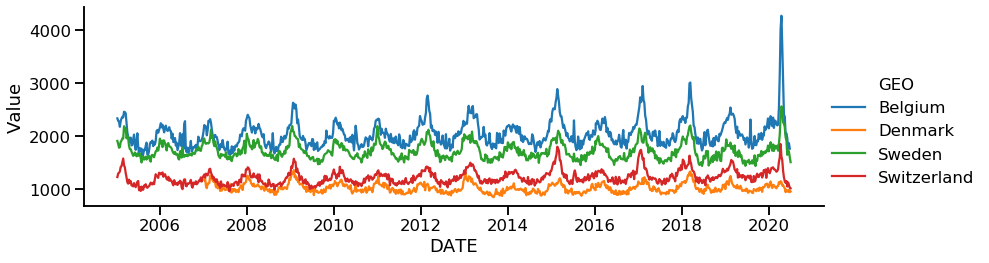

In [156]:
x = df[df.GEO.isin(countries1)]
g=sns.relplot(x='DATE',y='Value',data=x,kind='line',aspect=3,height=4,hue='GEO',estimator=np.sum,ci=None)
g.savefig('eurostat_flu_cycle.png')

## Plot totals up to week 26 per year for a subset of countries using catplot

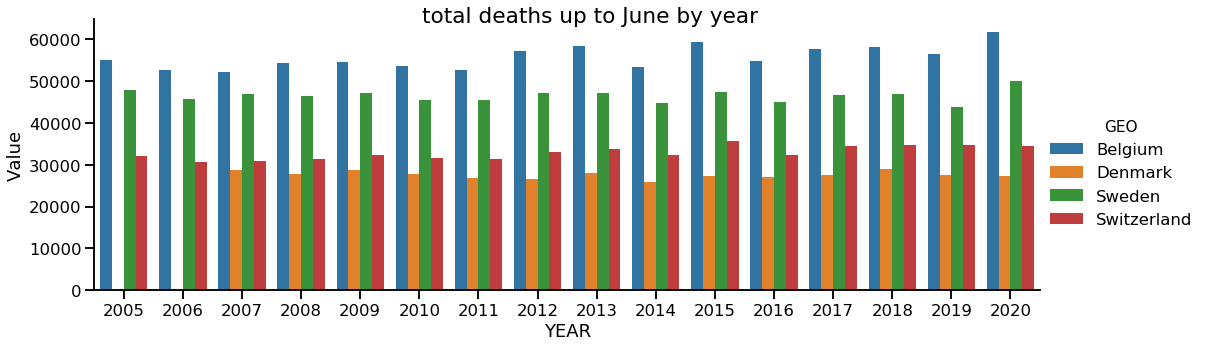

In [193]:
sub = df[df.WEEK<=26]
x = sub[sub.GEO.isin(countries1)]
g=sns.catplot(x='YEAR',y='Value',data=x,kind='bar',aspect=3,hue='GEO',estimator=np.sum,ci=None)
g.fig.suptitle('total deaths up to June by year')
g.fig.savefig('eurostat_4countries_totaldeaths.png')

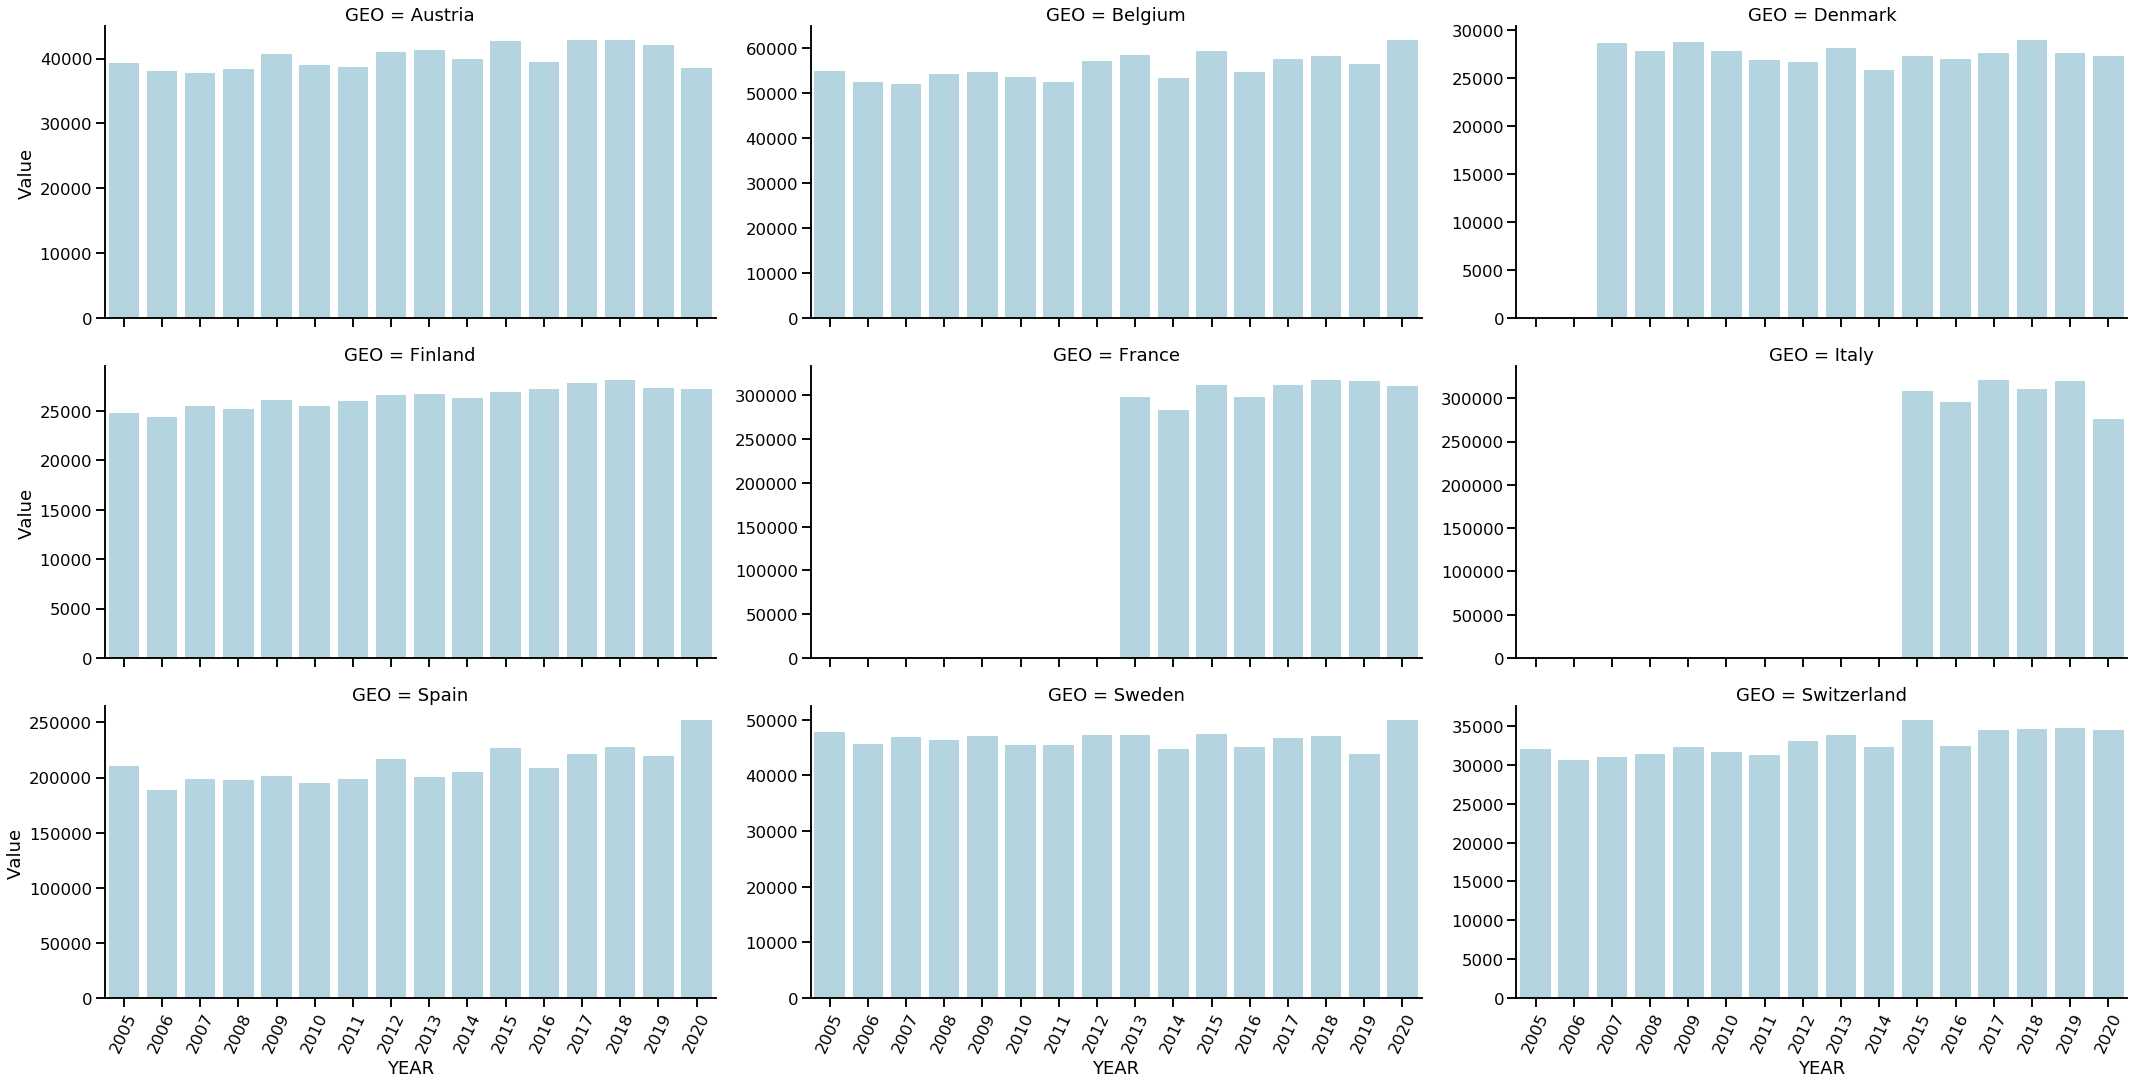

In [115]:
sns.set_context("talk")
x = sub[sub.GEO.isin(all)]
g=sns.catplot(x='YEAR',y='Value',data=x,kind='bar',aspect=2,col='GEO',col_wrap=3,sharey=False,estimator=np.sum,ci=None,color='lightblue')
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='center')
g.fig.savefig('eurostat_totaldeaths_bycountry.png')

## compare given period by age group

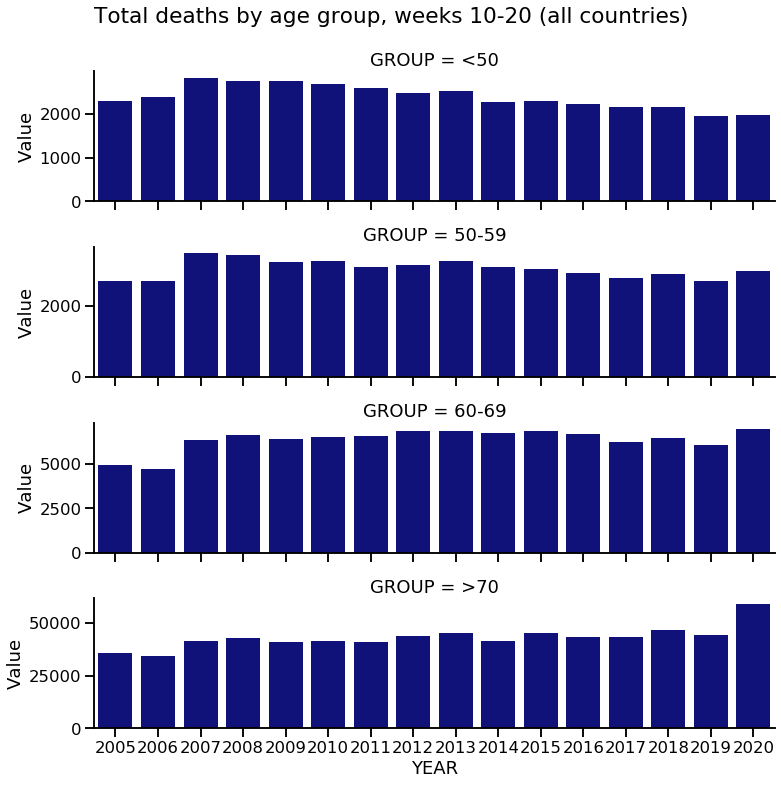

In [188]:
x = raw[raw.GEO.isin(countries1)]
#x = x[x.AGE.isin(old)]
x = x[(x.WEEK>10) & (x.WEEK<20)] 
g=sns.catplot(x='YEAR',y='Value',data=x,kind='bar',sharey=False,aspect=4,height=2.8,row='GROUP',estimator=np.sum,ci=None,color='darkblue')
g.fig.suptitle('Total deaths by age group, weeks 10-20 (all countries)')
plt.subplots_adjust(top=0.9)
g.fig.savefig('eurostat_fluseason_deaths.png')

## covid peak shown with mean across years

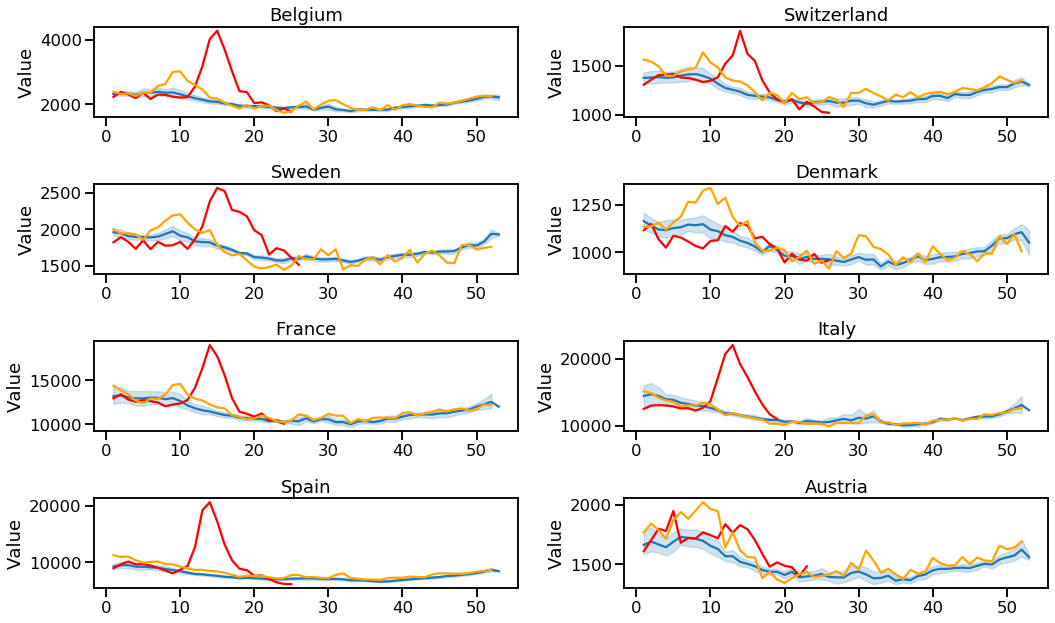

In [132]:
f,ax=plt.subplots(4,2,figsize=(15,9))
axs=ax.flat

def plot_trend(x,ax):
    mx = x[x.YEAR!=2020]    
    sns.lineplot(x="WEEK", y="Value", data=mx,ax=ax)
    s = x[x.YEAR==2020]
    sns.lineplot(x='WEEK',y='Value',data=s, color='red',ax=ax)
    s = x[x.YEAR==2018]
    sns.lineplot(x='WEEK',y='Value',data=s, color='orange',ax=ax)
    ax.set_xlabel('')
    return 

i=0
for c in all[:8]:    
    x = df[df.GEO==c]    
    g=plot_trend(x,ax=axs[i])    
    axs[i].set_title(c)
    i+=1
    
plt.tight_layout()
f.savefig('eurostat_2020peak_trend.png')

## age breakdown

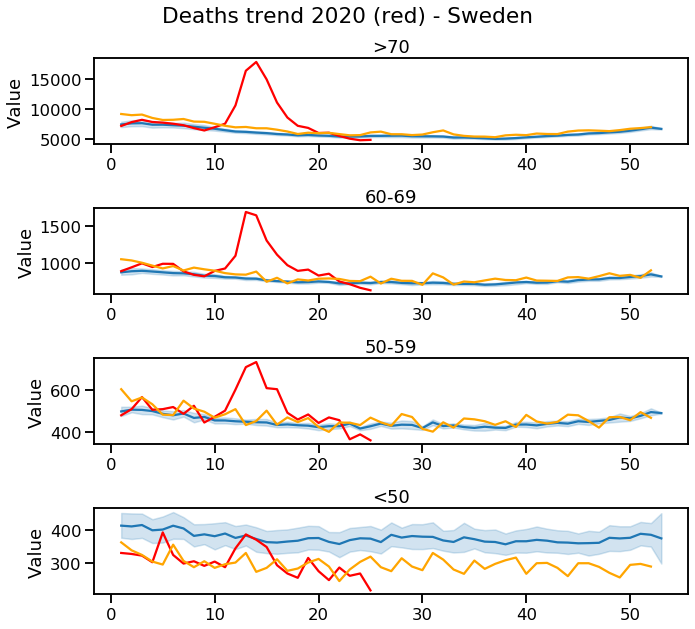

In [198]:
#print (oldest,old,middle,young)
cats = {'>70':oldest,'60-69':old,'50-59':middle,'<50':young}

f,ax=plt.subplots(4,1,figsize=(10,9))
axs=ax.flat
i=0
country='Spain'
for c in cats:    
    x = raw[(raw.GEO==country)]
    x = x[x.AGE.isin(cats[c])]
    x = x.groupby(['TIME','YEAR','WEEK','GEO']).agg({'Value':np.sum}).reset_index().replace(0,np.nan)
    g=plot_trend(x,ax=axs[i])    
    axs[i].set_title(c)
    i+=1   
plt.tight_layout()
f.suptitle('Deaths trend 2020 (red) - Sweden')
plt.subplots_adjust(top=0.9)
f.savefig('eurostat_2020peak_trend_byage_spain.png')

In [ ]:
x = raw[raw.GEO=='Sweden']
g=sns.catplot(x='GEO',y='Value',data=x,kind='bar',aspect=2,hue='AGE',col='YEAR',col_wrap=2,
              sharey=False,estimator=np.sum,ci=None,palette='Set2')


# CSO Covid deaths Ireland

https://www.cso.ie/en/releasesandpublications/br/b-cdc/covid-19deathsandcasesseries4/


In [17]:
cso=pd.read_csv('cso_deaths.csv')
cso['cfr'] = (cso.deaths/cso.cases).round(3)
cso['perc'] = (cso.deaths/cso.deaths.sum())
cso

,age,deaths,median_age_deaths,cases,median_age_cases,cfr,perc
0,0-24,0,20,2340,21,0.000,0.000000
1,25-44,0,38,8656,35,0.000,0.000000
2,45-64,85,58,7758,53,0.011,0.060584
3,65-79,397,74,2807,73,0.141,0.282965
4,80+,921,87,3609,86,0.255,0.656450


In [18]:
cso.deaths.sum()/

SyntaxError: invalid syntax (<ipython-input-18-2107f57f9b4f>, line 1)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(8,5))
#ax=axs.flat
cso.plot('age','deaths',kind='barh',ax=ax,legend=False,lw=1,ec='black')
ax.set_title('CSO Covid-19 total deaths Ireland, 28 February to 5 June 2020')
rects = ax.patches
labels=cso.cfr
for rect, label in zip(rects, labels):
    h = rect.get_height()
    w = rect.get_width()
    ax.text(rect.get_x()+w+40, rect.get_y()+h/4, label,
            ha='center', va='bottom', color='darkred')
plt.savefig('cso_deaths.png',dpi=130)
